## Import packages

In [1]:
import joblib
import os
import time
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import xgboost as xgb
from PIL import Image
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Define constants

In [3]:
# Define paths to preprocessed dataframes
TRAINING_DATA_PATH = Path("../dataset/preprocessed_train.csv")
TESTING_DATA_PATH = Path("../dataset/preprocessed_test.csv")

## Read training set

In [4]:
training_df = pd.read_csv(TRAINING_DATA_PATH)
training_df

,label,x1,y1,x2,y2,width,height,image_path,image_0,image_1,...,text_374,text_375,text_376,text_377,text_378,text_379,text_380,text_381,text_382,text_383
0,O,72,25,130,64,463,1013,../data/SROIE/training_data/images/X0001646961...,0.066298,0.638543,...,-0.018601,-0.019370,0.066925,0.045452,-0.057851,-0.004374,0.075019,-0.046913,0.009844,0.018009
1,O,135,25,213,64,463,1013,../data/SROIE/training_data/images/X0001646961...,0.068967,0.371842,...,0.050312,0.007405,0.033761,0.020477,-0.030148,0.028920,0.087345,0.075111,-0.014435,0.002013
2,O,218,25,296,64,463,1013,../data/SROIE/training_data/images/X0001646961...,0.026985,0.528665,...,0.028817,-0.006624,0.087021,-0.015899,-0.068072,0.043260,0.043504,-0.015771,-0.004515,-0.003918
3,O,50,82,102,121,463,1013,../data/SROIE/training_data/images/X0001646961...,0.015318,0.265603,...,0.028864,0.015455,-0.007574,0.031233,-0.062695,0.011160,0.108475,-0.002364,-0.035077,0.034739
4,O,107,82,133,121,463,1013,../data/SROIE/training_data/images/X0001646961...,0.260647,0.077965,...,0.019180,-0.032818,0.042829,0.008246,-0.048868,0.029558,0.237447,0.050727,0.024627,-0.073106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72384,O,189,837,214,853,619,875,../data/SROIE/training_data/images/X5100945380...,2.169962,0.640364,...,-0.020151,-0.031325,0.012688,0.037657,-0.035436,0.017989,0.110137,-0.027766,0.003398,0.020864
72385,O,219,837,288,853,619,875,../data/SROIE/training_data/images/X5100945380...,1.638891,0.103452,...,0.003119,0.009128,0.018742,0.022210,-0.048480,-0.016567,0.059354,0.016316,-0.004043,-0.042065
72386,O,293,837,344,853,619,875,../data/SROIE/training_data/images/X5100945380...,1.029949,0.017277,...,0.009359,0.047324,-0.017008,-0.027192,-0.002973,0.099714,0.121113,0.042193,0.039432,-0.055125
72387,O,349,837,409,853,619,875,../data/SROIE/training_data/images/X5100945380...,1.541287,0.177446,...,-0.041909,-0.032921,0.021997,0.050522,0.000761,-0.029530,0.039033,-0.021548,-0.049153,0.044922


In [5]:
training_df["x1"] = (training_df["x1"] - training_df.groupby("image_path")["x1"].transform('min')) / (training_df.groupby("image_path")["x2"].transform('max') - training_df.groupby("image_path")["x1"].transform('min'))
training_df["x2"] = (training_df["x2"] - training_df.groupby("image_path")["x1"].transform('min')) / (training_df.groupby("image_path")["x2"].transform('max') - training_df.groupby("image_path")["x1"].transform('min'))
training_df["y1"] = (training_df["y1"] - training_df.groupby("image_path")["y1"].transform('min')) / (training_df.groupby("image_path")["y2"].transform('max') - training_df.groupby("image_path")["y1"].transform('min'))
training_df["y2"] = (training_df["y2"] - training_df.groupby("image_path")["y1"].transform('min')) / (training_df.groupby("image_path")["y2"].transform('max') - training_df.groupby("image_path")["y1"].transform('min'))
training_df["position"] = training_df.groupby("image_path").cumcount() + 1
training_df.drop(["width", "height"], axis=1, inplace=True)
training_df

,label,x1,y1,x2,y2,image_path,text_length,alpha_count,num_count,image_0,...,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767,position
0,O,0.108173,0.000000,0.293454,0.065507,../data/SROIE/training_data/images/X0001646961...,3,3,0,0.000000,...,0.011357,-0.025010,-0.020825,-0.042661,0.036733,-0.039157,0.024713,-0.051543,-0.008242,1
1,O,0.259615,0.000000,0.480813,0.065507,../data/SROIE/training_data/images/X0001646961...,4,4,0,0.033484,...,-0.006533,0.063699,0.007715,-0.005969,0.054672,0.054480,0.062522,-0.044647,-0.013282,2
2,O,0.459135,0.000000,0.668172,0.065507,../data/SROIE/training_data/images/X0001646961...,4,4,0,0.049087,...,0.001297,-0.008407,-0.009319,-0.012464,0.026040,0.032243,0.006994,-0.057619,-0.036633,3
3,O,0.055288,0.059874,0.230248,0.123849,../data/SROIE/training_data/images/X0001646961...,4,4,0,0.041585,...,-0.039189,0.010518,-0.001245,-0.011138,0.062873,-0.002950,0.015333,-0.052296,-0.024258,4
4,O,0.192308,0.059874,0.300226,0.123849,../data/SROIE/training_data/images/X0001646961...,2,2,0,0.000000,...,0.044875,0.008178,-0.028312,0.003375,0.026132,-0.011436,-0.009047,-0.012535,0.002621,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72384,O,0.337278,0.980861,0.407619,1.000000,../data/SROIE/training_data/images/X5100945380...,3,3,0,0.054577,...,0.017989,0.019470,-0.001860,-0.035593,0.052716,-0.001316,0.018626,-0.044441,0.005682,95
72385,O,0.396450,0.980861,0.548571,1.000000,../data/SROIE/training_data/images/X5100945380...,8,7,0,0.000000,...,-0.022961,0.059991,-0.006271,0.003093,-0.037735,-0.019850,0.058535,0.008770,0.022487,96
72386,O,0.542406,0.980861,0.655238,1.000000,../data/SROIE/training_data/images/X5100945380...,6,6,0,0.000000,...,0.078342,0.057747,-0.000286,-0.006738,-0.022748,-0.016694,-0.026390,0.023161,-0.031222,97
72387,O,0.652860,0.980861,0.779048,1.000000,../data/SROIE/training_data/images/X5100945380...,7,7,0,0.004133,...,0.039431,0.026870,0.021478,-0.019944,0.003892,0.028598,0.009909,-0.035573,0.002492,98


## Assign column names

In [5]:
X_train = training_df.drop(["image_path", "label"], axis=1)
y_train = training_df["label"]
X_train

,x1,y1,x2,y2,width,height,image_0,image_1,image_2,image_3,...,text_374,text_375,text_376,text_377,text_378,text_379,text_380,text_381,text_382,text_383
0,72,25,130,64,463,1013,0.066298,0.638543,1.882016,0.137599,...,-0.018601,-0.019370,0.066925,0.045452,-0.057851,-0.004374,0.075019,-0.046913,0.009844,0.018009
1,135,25,213,64,463,1013,0.068967,0.371842,0.065209,0.280368,...,0.050312,0.007405,0.033761,0.020477,-0.030148,0.028920,0.087345,0.075111,-0.014435,0.002013
2,218,25,296,64,463,1013,0.026985,0.528665,0.572134,0.468849,...,0.028817,-0.006624,0.087021,-0.015899,-0.068072,0.043260,0.043504,-0.015771,-0.004515,-0.003918
3,50,82,102,121,463,1013,0.015318,0.265603,0.400063,0.026905,...,0.028864,0.015455,-0.007574,0.031233,-0.062695,0.011160,0.108475,-0.002364,-0.035077,0.034739
4,107,82,133,121,463,1013,0.260647,0.077965,1.439568,0.104909,...,0.019180,-0.032818,0.042829,0.008246,-0.048868,0.029558,0.237447,0.050727,0.024627,-0.073106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72384,189,837,214,853,619,875,2.169962,0.640364,2.301084,0.574548,...,-0.020151,-0.031325,0.012688,0.037657,-0.035436,0.017989,0.110137,-0.027766,0.003398,0.020864
72385,219,837,288,853,619,875,1.638891,0.103452,0.013597,0.018407,...,0.003119,0.009128,0.018742,0.022210,-0.048480,-0.016567,0.059354,0.016316,-0.004043,-0.042065
72386,293,837,344,853,619,875,1.029949,0.017277,0.448898,0.097961,...,0.009359,0.047324,-0.017008,-0.027192,-0.002973,0.099714,0.121113,0.042193,0.039432,-0.055125
72387,349,837,409,853,619,875,1.541287,0.177446,0.122035,0.013562,...,-0.041909,-0.032921,0.021997,0.050522,0.000761,-0.029530,0.039033,-0.021548,-0.049153,0.044922


In [7]:
# Drop certain features to try different feature combinations
# X_train = X_train.drop(["x1", "y1", "x2", "y2", "width", "height"], axis=1)
# X_train = X_train.drop([f"image_{i}" for i in range(512)], axis=1)
# X_train = X_train.drop([f"text_{i}" for i in range(384)], axis=1)

In [7]:
print("X_train shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train shape: (72389, 900)
y_train.shape: (72389,)


## Read test set

In [8]:
testing_df = pd.read_csv(TESTING_DATA_PATH)
testing_df

,label,x1,y1,x2,y2,width,height,image_path,image_0,image_1,...,text_374,text_375,text_376,text_377,text_378,text_379,text_380,text_381,text_382,text_383
0,O,98,26,153,66,463,894,../data/SROIE/testing_data/images/X00016469670...,0.170721,0.721371,...,-0.018601,-0.019370,0.066925,0.045452,-0.057851,-0.004374,0.075019,-0.046913,0.009844,0.018009
1,O,158,26,232,66,463,894,../data/SROIE/testing_data/images/X00016469670...,0.091009,1.033792,...,0.063969,-0.005894,0.033699,-0.028355,-0.091819,0.014065,0.121330,0.035628,0.043011,-0.097556
2,O,237,26,292,66,463,894,../data/SROIE/testing_data/images/X00016469670...,0.129165,1.493914,...,0.077571,-0.002263,0.008373,-0.042771,0.031590,0.007713,0.043854,-0.029860,0.027789,-0.083567
3,O,138,95,173,120,463,894,../data/SROIE/testing_data/images/X00016469670...,0.048240,0.052771,...,0.046517,-0.021178,0.038415,-0.001368,0.003937,0.041348,0.074261,0.042509,0.030241,0.005588
4,O,178,95,225,120,463,894,../data/SROIE/testing_data/images/X00016469670...,0.069463,0.234998,...,0.058546,-0.022949,0.041816,0.025118,0.004478,0.076240,0.141040,0.034836,0.065118,-0.022675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39675,O,405,1589,443,1623,884,1678,../data/SROIE/testing_data/images/X51009568881...,1.067353,0.337025,...,0.071456,0.046265,0.027016,-0.026072,-0.000888,0.053133,0.130573,0.066164,0.019923,-0.040140
39676,O,448,1589,525,1623,884,1678,../data/SROIE/testing_data/images/X51009568881...,0.470101,0.114816,...,0.029483,-0.056955,0.005536,0.048313,-0.076761,0.019887,0.038670,-0.078271,-0.035144,-0.021723
39677,O,530,1589,555,1623,884,1678,../data/SROIE/testing_data/images/X51009568881...,0.419684,0.000000,...,0.064742,0.030619,-0.023806,-0.034125,-0.061991,0.045208,0.128920,-0.013236,0.113059,-0.061580
39678,O,560,1589,663,1623,884,1678,../data/SROIE/testing_data/images/X51009568881...,0.983048,0.097415,...,-0.029090,0.011833,-0.051970,0.023080,-0.007291,0.023660,0.036289,-0.017813,-0.036859,-0.009218


In [10]:
testing_df["x1"] = (testing_df["x1"] - testing_df.groupby("image_path")["x1"].transform('min')) / (testing_df.groupby("image_path")["x2"].transform('max') - testing_df.groupby("image_path")["x1"].transform('min'))
testing_df["x2"] = (testing_df["x2"] - testing_df.groupby("image_path")["x1"].transform('min')) / (testing_df.groupby("image_path")["x2"].transform('max') - testing_df.groupby("image_path")["x1"].transform('min'))
testing_df["y1"] = (testing_df["y1"] - testing_df.groupby("image_path")["y1"].transform('min')) / (testing_df.groupby("image_path")["y2"].transform('max') - testing_df.groupby("image_path")["y1"].transform('min'))
testing_df["y2"] = (testing_df["y2"] - testing_df.groupby("image_path")["y1"].transform('min')) / (testing_df.groupby("image_path")["y2"].transform('max') - testing_df.groupby("image_path")["y1"].transform('min'))
testing_df["position"] = testing_df.groupby("image_path").cumcount() + 1
testing_df.drop(["width", "height"], axis=1, inplace=True)
testing_df

,label,x1,y1,x2,y2,image_path,text_length,alpha_count,num_count,image_0,...,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767,position
0,O,0.217877,0.000000,0.404762,0.074492,../data/SROIE/testing_data/images/X00016469670...,3,3,0,0.000000,...,0.011357,-0.025010,-0.020825,-0.042661,0.036733,-0.039157,0.024713,-0.051543,-0.008242,1
1,O,0.385475,0.000000,0.613757,0.074492,../data/SROIE/testing_data/images/X00016469670...,4,4,0,0.000000,...,-0.005370,0.031561,-0.010384,0.005535,0.030147,-0.026708,0.090474,-0.073575,-0.002189,2
2,O,0.606145,0.000000,0.772487,0.074492,../data/SROIE/testing_data/images/X00016469670...,3,3,0,0.000000,...,-0.008285,0.069396,0.009720,0.003281,0.011498,0.014066,0.052029,-0.011903,-0.025509,3
3,O,0.329609,0.080233,0.457672,0.135440,../data/SROIE/testing_data/images/X00016469670...,3,0,0,0.000000,...,0.037223,0.064261,-0.003410,0.010620,0.033925,-0.028956,0.024285,0.016989,-0.022417,4
4,O,0.441341,0.080233,0.595238,0.135440,../data/SROIE/testing_data/images/X00016469670...,4,4,0,0.000000,...,0.054217,0.012378,-0.007393,-0.006583,0.043897,-0.016967,-0.009654,0.039707,-0.039091,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39675,O,0.470588,0.974759,0.546914,1.000000,../data/SROIE/testing_data/images/X51009568881...,3,3,0,0.030140,...,0.045012,-0.028122,0.016033,-0.011445,0.034254,-0.036234,-0.016313,-0.038186,-0.005211,107
39676,O,0.526797,0.974759,0.648148,1.000000,../data/SROIE/testing_data/images/X51009568881...,6,6,0,0.001026,...,0.002829,-0.026024,0.009414,-0.002522,0.032373,0.028129,-0.025444,0.025688,0.019491,108
39677,O,0.633987,0.974759,0.685185,1.000000,../data/SROIE/testing_data/images/X51009568881...,2,2,0,0.203418,...,0.002977,-0.001757,0.006616,0.002489,0.055948,-0.003405,-0.017903,-0.108177,-0.007096,109
39678,O,0.673203,0.974759,0.818519,1.000000,../data/SROIE/testing_data/images/X51009568881...,8,8,0,0.007481,...,-0.016412,0.072695,0.019480,-0.016180,0.047412,-0.028888,-0.005228,0.011755,-0.033923,110


In [9]:
X_test = testing_df.drop(["image_path", "label"], axis=1)
y_test = testing_df["label"]
X_test

,x1,y1,x2,y2,width,height,image_0,image_1,image_2,image_3,...,text_374,text_375,text_376,text_377,text_378,text_379,text_380,text_381,text_382,text_383
0,98,26,153,66,463,894,0.170721,0.721371,2.546469,0.143199,...,-0.018601,-0.019370,0.066925,0.045452,-0.057851,-0.004374,0.075019,-0.046913,0.009844,0.018009
1,158,26,232,66,463,894,0.091009,1.033792,0.399626,0.000037,...,0.063969,-0.005894,0.033699,-0.028355,-0.091819,0.014065,0.121330,0.035628,0.043011,-0.097556
2,237,26,292,66,463,894,0.129165,1.493914,1.005861,0.192958,...,0.077571,-0.002263,0.008373,-0.042771,0.031590,0.007713,0.043854,-0.029860,0.027789,-0.083567
3,138,95,173,120,463,894,0.048240,0.052771,0.501752,0.621102,...,0.046517,-0.021178,0.038415,-0.001368,0.003937,0.041348,0.074261,0.042509,0.030241,0.005588
4,178,95,225,120,463,894,0.069463,0.234998,0.127180,0.119083,...,0.058546,-0.022949,0.041816,0.025118,0.004478,0.076240,0.141040,0.034836,0.065118,-0.022675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39675,405,1589,443,1623,884,1678,1.067353,0.337025,1.275657,0.327466,...,0.071456,0.046265,0.027016,-0.026072,-0.000888,0.053133,0.130573,0.066164,0.019923,-0.040140
39676,448,1589,525,1623,884,1678,0.470101,0.114816,0.080597,0.072923,...,0.029483,-0.056955,0.005536,0.048313,-0.076761,0.019887,0.038670,-0.078271,-0.035144,-0.021723
39677,530,1589,555,1623,884,1678,0.419684,0.000000,3.125401,0.517783,...,0.064742,0.030619,-0.023806,-0.034125,-0.061991,0.045208,0.128920,-0.013236,0.113059,-0.061580
39678,560,1589,663,1623,884,1678,0.983048,0.097415,0.018130,0.026867,...,-0.029090,0.011833,-0.051970,0.023080,-0.007291,0.023660,0.036289,-0.017813,-0.036859,-0.009218


In [12]:
# X_test = X_test.drop(["x1", "y1", "x2", "y2", "width", "height"], axis=1)
# X_test = X_test.drop([f"image_{i}" for i in range(512)], axis=1)
# X_test = X_test.drop([f"text_{i}" for i in range(384)], axis=1)

## Scaling

In [11]:
X_train["x1"] /= X_train["width"]
X_train["y1"] /= X_train["height"]
X_train["x2"] /= X_train["width"]
X_train["y2"] /= X_train["height"]
X_train.drop(["width", "height"], axis=1, inplace=True)
X_train

,x1,y1,x2,y2,text_0,text_1,text_2,text_3,text_4,text_5,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,0.155508,0.024679,0.280778,0.063179,0.002108,0.021258,-0.007206,-0.034536,-0.019322,-0.007933,...,-0.043179,0.011357,-0.025010,-0.020825,-0.042661,0.036733,-0.039157,0.024713,-0.051543,-0.008242
1,0.291577,0.024679,0.460043,0.063179,-0.023645,0.007873,-0.012703,0.014459,-0.023599,0.016394,...,0.045743,-0.006533,0.063699,0.007715,-0.005969,0.054672,0.054480,0.062522,-0.044647,-0.013282
2,0.470842,0.024679,0.639309,0.063179,0.006481,0.007707,0.013341,0.001375,-0.039583,-0.016273,...,0.009353,0.001297,-0.008407,-0.009319,-0.012464,0.026040,0.032243,0.006994,-0.057619,-0.036633
3,0.107991,0.080948,0.220302,0.119447,0.020654,0.052724,-0.012566,-0.022447,-0.074496,0.025872,...,-0.103987,-0.039189,0.010518,-0.001245,-0.011138,0.062873,-0.002950,0.015333,-0.052296,-0.024258
4,0.231102,0.080948,0.287257,0.119447,-0.002700,-0.084097,-0.021065,0.070500,0.021717,0.007690,...,-0.040041,0.044875,0.008178,-0.028312,0.003375,0.026132,-0.011436,-0.009047,-0.012535,0.002621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72384,0.305331,0.956571,0.345719,0.974857,0.030286,0.029233,0.021978,-0.018922,-0.027277,-0.010707,...,0.006633,0.017989,0.019470,-0.001860,-0.035593,0.052716,-0.001316,0.018626,-0.044441,0.005682
72385,0.353796,0.956571,0.465267,0.974857,0.003986,-0.050904,0.011518,0.062105,-0.055821,0.011792,...,0.012693,-0.022961,0.059991,-0.006271,0.003093,-0.037735,-0.019850,0.058535,0.008770,0.022487
72386,0.473344,0.956571,0.555735,0.974857,-0.009183,0.081294,0.011734,0.009715,-0.054004,0.053299,...,0.025878,0.078342,0.057747,-0.000286,-0.006738,-0.022748,-0.016694,-0.026390,0.023161,-0.031222
72387,0.563813,0.956571,0.660743,0.974857,0.051567,-0.002766,-0.028658,0.029357,0.014355,0.041320,...,0.002591,0.039431,0.026870,0.021478,-0.019944,0.003892,0.028598,0.009909,-0.035573,0.002492


In [12]:
X_test["x1"] /= X_test["width"]
X_test["y1"] /= X_test["height"]
X_test["x2"] /= X_test["width"]
X_test["y2"] /= X_test["height"]
X_test.drop(["width", "height"], axis=1, inplace=True)
X_test

,x1,y1,x2,y2,text_0,text_1,text_2,text_3,text_4,text_5,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,0.211663,0.029083,0.330454,0.073826,0.002108,0.021258,-0.007206,-0.034536,-0.019322,-0.007933,...,-0.043179,0.011357,-0.025010,-0.020825,-0.042661,0.036733,-0.039157,0.024713,-0.051543,-0.008242
1,0.341253,0.029083,0.501080,0.073826,0.010147,0.015729,0.032068,0.013532,0.000584,0.032537,...,-0.013091,-0.005370,0.031561,-0.010384,0.005535,0.030147,-0.026708,0.090474,-0.073575,-0.002189
2,0.511879,0.029083,0.630670,0.073826,-0.002721,-0.012054,-0.028510,-0.000896,0.038223,0.041746,...,0.037081,-0.008285,0.069396,0.009720,0.003281,0.011498,0.014066,0.052029,-0.011903,-0.025509
3,0.298056,0.106264,0.373650,0.134228,-0.043491,0.038184,-0.050022,0.018172,0.033525,0.011394,...,-0.002816,0.037223,0.064261,-0.003410,0.010620,0.033925,-0.028956,0.024285,0.016989,-0.022417
4,0.384449,0.106264,0.485961,0.134228,-0.008245,0.029143,-0.016950,0.036566,-0.050979,0.038815,...,-0.013525,0.054217,0.012378,-0.007393,-0.006583,0.043897,-0.016967,-0.009654,0.039707,-0.039091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39675,0.458145,0.946961,0.501131,0.967223,0.054792,-0.001494,-0.010163,0.020250,-0.044029,0.044745,...,-0.021914,0.045012,-0.028122,0.016033,-0.011445,0.034254,-0.036234,-0.016313,-0.038186,-0.005211
39676,0.506787,0.946961,0.593891,0.967223,0.010424,0.007442,-0.013804,0.015057,-0.026168,0.039130,...,-0.079042,0.002829,-0.026024,0.009414,-0.002522,0.032373,0.028129,-0.025444,0.025688,0.019491
39677,0.599548,0.946961,0.627828,0.967223,-0.027917,0.102889,-0.005668,-0.044251,-0.012371,0.010943,...,0.038565,0.002977,-0.001757,0.006616,0.002489,0.055948,-0.003405,-0.017903,-0.108177,-0.007096
39678,0.633484,0.946961,0.750000,0.967223,0.041673,-0.011111,0.014192,0.039974,0.004348,0.002587,...,-0.046166,-0.016412,0.072695,0.019480,-0.016180,0.047412,-0.028888,-0.005228,0.011755,-0.033923


In [11]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
# If no positional coordinates are present

X_train.drop(["width", "height"], axis=1, inplace=True)
X_test.drop(["width", "height"], axis=1, inplace=True)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# If positional coordinates are present

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(["x1", "x2", "y1", "y2"], axis=1))
X_test_scaled = scaler.transform(X_test.drop(["x1", "x2", "y1", "y2"], axis=1))

selected_features = [col for col in X_train.columns if col not in ("x1", "y1", "x2", "y2")]
X_train[selected_features] = X_train_scaled
X_test[selected_features] = X_test_scaled

## Train model

In [14]:
param_grid = {
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Subsample ratio of columns when constructing each tree
}

In [15]:
def pipeline(subsample, colsample_bytree):
    model = xgb.XGBClassifier(
        objective="multi:softmax", 
        num_class=len(le.classes_), 
        random_state=0, 
        nthread=-1,
        tree_method="gpu_hist",
        gpu_id=0,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_hat = le.inverse_transform(y_hat)
    score = evaluate(y_test, y_hat, le.classes_, show=False)
    
    del model
    return score

In [17]:
highest_score = -1

for subsample in param_grid["subsample"]:
    for colsample in param_grid["colsample_bytree"]:
        f1_value = pipeline(subsample, colsample)
        
        if f1_value > highest_score:
            highest_score = f1_value
            print(f"HIGHEST SCORE! SUBSAMPLE - {subsample}, COLSAMPLE - {colsample}, F1 Score - {f1_value}")
        else:
            print(f"SUBSAMPLE - {subsample}, COLSAMPLE - {colsample}, F1 Score - {f1_value}")

HIGHEST SCORE! SUBSAMPLE - 0.1, COLSAMPLE - 0.1, F1 Score - 0.902635369883908
HIGHEST SCORE! SUBSAMPLE - 0.1, COLSAMPLE - 0.2, F1 Score - 0.9082003209188413
HIGHEST SCORE! SUBSAMPLE - 0.1, COLSAMPLE - 0.3, F1 Score - 0.9139875441844806
SUBSAMPLE - 0.1, COLSAMPLE - 0.4, F1 Score - 0.9116852414724755
SUBSAMPLE - 0.1, COLSAMPLE - 0.5, F1 Score - 0.9116953151331312
HIGHEST SCORE! SUBSAMPLE - 0.1, COLSAMPLE - 0.6, F1 Score - 0.9144831072541916
SUBSAMPLE - 0.1, COLSAMPLE - 0.7, F1 Score - 0.914021052631579
SUBSAMPLE - 0.1, COLSAMPLE - 0.8, F1 Score - 0.9124136769412161
SUBSAMPLE - 0.1, COLSAMPLE - 0.9, F1 Score - 0.9102596633680116
HIGHEST SCORE! SUBSAMPLE - 0.1, COLSAMPLE - 1.0, F1 Score - 0.9152314542552297
SUBSAMPLE - 0.2, COLSAMPLE - 0.1, F1 Score - 0.913762401424574
HIGHEST SCORE! SUBSAMPLE - 0.2, COLSAMPLE - 0.2, F1 Score - 0.9162011173184357
HIGHEST SCORE! SUBSAMPLE - 0.2, COLSAMPLE - 0.3, F1 Score - 0.9206832403179436
HIGHEST SCORE! SUBSAMPLE - 0.2, COLSAMPLE - 0.4, F1 Score - 0.9241

In [12]:
# Define the model
model = xgb.XGBClassifier(
    objective="multi:softmax", 
    num_class=len(le.classes_), 
    random_state=0, 
    nthread=-1,
    tree_method="gpu_hist",
    gpu_id=0,
    subsample=0.9,
    colsample_bytree=0.9
)
# model = RandomForestClassifier(random_state=0, n_jobs=-1)
# model = LogisticRegression(random_state=0, n_jobs=-1, multi_class="multinomial", solver="lbfgs")

In [13]:
start = time.time()
model.fit(X_train, y_train)
end = time.time()

print("Elapsed time for training (in seconds):", end-start)

Elapsed time for training (in seconds): 33.13369417190552


In [14]:
model_in_mem = joblib.dump(model, "./model.joblib")

size_in_bytes = os.path.getsize("./model.joblib")

print(f"Model size: {size_in_bytes / (1024 * 1024)} MB")

Model size: 1.5538043975830078 MB


## Evaluate

In [15]:
def evaluate(test_y, pred_y, labels, show=True):
    """
    Calculate metrics.
    :param test_y: True labels.
    :param pred_y: Predicted labels.
    :param labels: Label names.
    """
    cm = confusion_matrix(test_y, pred_y, labels=labels)
    
    if show:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.show()
    
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    report = classification_report(test_y, pred_y)
    per_class_accuracy = cm.diagonal()/cm.sum(axis=1)

    if show:
        print("-----Entity level-----")
        print("Precision: {:.2f}".format(precision))
        print("Recall: {:.2f}".format(recall))
        print("F1-Score: {:.2f}\n".format(f1))
        print("Classification report:", report)
        print('*' * 50)

        print("Class name\tAccuracy")
        print('*' * 50)

        for class_name, accuracy in zip(labels, per_class_accuracy):
            print("{0:10}\t{1:.2f}".format(class_name, accuracy))
        
    return f1

Elapsed time for inference (in seconds): 0.4125044345855713


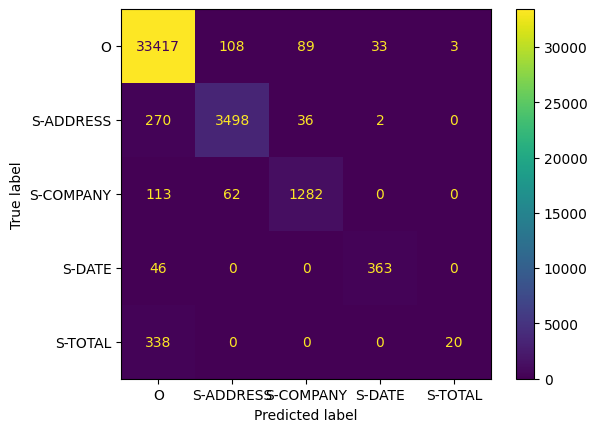

-----Entity level-----
Precision: 0.94
Recall: 0.86
F1-Score: 0.90

Classification report:            precision    recall  f1-score   support

 ADDRESSO       0.95      0.92      0.94      3806
    DATEO       0.91      0.89      0.90       409
 COMPANYO       0.91      0.88      0.90      1457
   TOTALO       0.87      0.06      0.10       358

micro avg       0.94      0.86      0.90      6030
macro avg       0.94      0.86      0.87      6030

**************************************************
Class name	Accuracy
**************************************************
O         	0.99
S-ADDRESS 	0.92
S-COMPANY 	0.88
S-DATE    	0.89
S-TOTAL   	0.06


0.8958875585632482

In [16]:
start = time.time()
y_hat = model.predict(X_test)
end = time.time()

print("Elapsed time for inference (in seconds):", end-start)

# evaluate(y_test, y_hat, model.classes_)

y_hat = le.inverse_transform(y_hat)
evaluate(y_test, y_hat, le.classes_)